# Analysis for Cardiomyocyte Differentiation figure
This processes the already qc-ed & aggregated measurements for the Cardiomyocyte Differentiation figure in the paper.

In [1]:
import ngio
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import umap
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

In [2]:
local_plate_url = "/Users/joel/Documents/TestDatasets/23well_benchmark/20200812-CardiomyocyteDifferentiation14-Cycle1_mip.zarr"
local_plate = ngio.open_ome_zarr_plate(local_plate_url)

In [3]:
df = local_plate.get_table("nuclei_measurements_qced").dataframe

In [4]:
df

nuclei_filtered_Morphology_area  nuclei_filtered_Morphology_centroid-0  \
label                                                                           
214                             6109.0                              87.627602   
215                             4718.0                              92.093262   
216                             4599.0                              91.097412   
217                             8068.0                             101.037308   
219                             3333.0                              88.151215   
...                                ...                                    ...   
73957                           3611.0                            2074.994385   
73964                           2288.0                            2075.985107   
73970                           2258.0                            2083.329590   
73978                           2402.0                            2074.787598   
73997                           2146.0                            2086.249268   

       nuclei_filtered_Morphology_centroid-1  \
label                                          
214                              1664.032715   
215                               165.185242   
216                              1477.827148   
217                               431.152832   
219                              1583.671509   
...                                      ...   
73957                             710.316284   
73964                             260.677002   
73970                             184.254211   
73978                             395.848450   
73997                            2250.247559   

       nuclei_filtered_Morphology_well_centroid-0  \
label                                               
214                                     87.627602   
215                                     92.093262   
216                                     91.097412   
217                                    101.037308   
219                                     88.151215   
...                                           ...   
73957                                19354.994141   
73964                                19355.984375   
73970                                19363.330078   
73978                                19354.787109   
73997                                19366.250000   

       nuclei_filtered_Morphology_well_centroid-1  \
label                                               
214                                   9344.033203   
215                                    165.185242   
216                                   6597.827148   
217                                   2991.152832   
219                                  14383.671875   
...                                           ...   
73957                                18630.316406   
73964                                10500.676758   
73970                                10424.253906   
73978                                18315.847656   
73997                                 9930.247070   

       nuclei_filtered_Morphology_bbox_area  \
label                                         
214                                  8475.0   
215                                  6162.0   
216                                  5920.0   
217                                  9797.0   
219                                  4599.0   
...                                     ...   
73957                                4900.0   
73964                                3283.0   
73970                                3213.0   
73978                                3034.0   
73997                                3397.0   

       nuclei_filtered_Morphology_bbox-0  nuclei_filtered_Morphology_bbox-1  \
label                                                                         
214                                 50.0                             1613.0   
215                                 51.0                              126.0   
216                 

In [5]:
# Clean up categoricals
classifier_cols = [
    "nanog_classifier", "Sox17_classifier",
    "NKX25_classifier", "TroponinT_classifier",
]
for classifier_col in classifier_cols:
    df[classifier_col] = (
        df[classifier_col]
        .cat.remove_unused_categories()
    )

# Helper functions

In [6]:
def shuffled_view(df_plot, seed=0):
    idx = np.random.default_rng(seed).permutation(len(df_plot))
    return df_plot.iloc[idx]

def savefig_both(outbase, dpi=300):
    """
    Save current Matplotlib figure as both PDF and PNG.
    outbase: path without suffix, e.g. "figs/umap_day"
    """
    outbase = Path(outbase)
    outbase.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(outbase.with_suffix(".pdf"), dpi=dpi, bbox_inches="tight")
    plt.savefig(outbase.with_suffix(".png"), dpi=dpi, bbox_inches="tight")


def umap_continuous_figure(df_plot, value_col, outbase=None, title=None,
                           s=2, alpha=0.8, cmap="viridis",
                           vmin=None, vmax=None, log_color=False):
    x = df_plot["UMAP1"].to_numpy()
    y = df_plot["UMAP2"].to_numpy()
    v = df_plot[value_col].to_numpy()

    if log_color:
        v = np.log1p(v)

    fig, ax = plt.subplots(figsize=(7, 6))
    sc = ax.scatter(
        x, y, c=v, s=s, alpha=alpha, linewidths=0,
        cmap=cmap, vmin=vmin, vmax=vmax, rasterized=True
    )

    ax.set_xlabel("UMAP1")
    ax.set_ylabel("UMAP2")
    ax.set_title(title or value_col)

    cb = fig.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)
    cb.set_label(value_col + (" (log1p)" if log_color else ""))

    xlim = (df_plot["UMAP1"].min(), df_plot["UMAP1"].max())
    ylim = (df_plot["UMAP2"].min(), df_plot["UMAP2"].max())
    # then in each plot:
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    fig.tight_layout()
    if outbase:
        savefig_both(outbase)
    return fig, ax


def umap_categorical_figure(
    df_plot,
    cat_col,
    outbase=None,
    title=None,
    s=2,
    alpha=0.8,
    max_categories=20,
    color_map=None,
    default_color="lightgray",
):
    """
    UMAP scatter with explicit category->color mapping.

    color_map: dict {category_label: color}
               if None, a default gray/green binary map is used
    """

    # ---- Default explicit colormap (binary-friendly)
    if color_map is None:
        color_map = {
            "nanog_negative": "lightgray",
            "nanog_positive": "#1b9e77",
            "Sox17_negative": "lightgray",
            "Sox17_positive": "#1b9e77",
            "NKX25_negative": "lightgray",
            "NKX25_positive": "#1b9e77",
            "TroponinT_negative": "lightgray",
            "TroponinT_positive": "#1b9e77",
        }

    # Ensure categorical and drop unused categories
    cats = (
        df_plot[cat_col]
        .astype("category")
        .cat.remove_unused_categories()
    )

    # Optional collapse if too many categories
    if cats.nunique() > max_categories:
        top = cats.value_counts().index[:max_categories]
        cats = cats.where(cats.isin(top), other="Other").astype("category")

    # Map categories -> colors (per-point!)
    colors = cats.map(color_map).fillna(default_color)

    # ---- Plot
    fig, ax = plt.subplots(figsize=(7, 6))
    ax.scatter(
        df_plot["UMAP1"],
        df_plot["UMAP2"],
        c=colors,
        s=s,
        alpha=alpha,
        linewidths=0,
        rasterized=True,
    )

    ax.set_xlabel("UMAP1")
    ax.set_ylabel("UMAP2")
    ax.set_title(title or cat_col)

    # ---- Legend (only categories that actually appear)
    legend_handles = []
    for cat in cats.cat.categories:
        col = color_map.get(cat, default_color)
        legend_handles.append(
            plt.Line2D(
                [0], [0],
                marker="o",
                linestyle="",
                color=col,
                label=str(cat),
                markersize=6,
            )
        )

    ax.legend(
        handles=legend_handles,
        bbox_to_anchor=(1.02, 1),
        loc="upper left",
        frameon=False,
        title=cat_col,
    )

    # ---- Axes polish
    ax.set_xlim(df_plot["UMAP1"].min(), df_plot["UMAP1"].max())
    ax.set_ylim(df_plot["UMAP2"].min(), df_plot["UMAP2"].max())
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    fig.tight_layout()

    if outbase:
        savefig_both(outbase)
    return fig, ax

# UMAP embedding

In [7]:
exclude_cols = [
    "well_name", "ROI",
    "nanog_classifier", "Sox17_classifier",
    "NKX25_classifier", "TroponinT_classifier",
    "differentiation_day",
]

X_scaled = StandardScaler().fit_transform(df.drop(columns=exclude_cols))

In [8]:
n_neighbors = 30  # test 10 - 100
min_dist = 0.05 # test 0.01 - 0.3
random_state=42

In [9]:
pca = PCA(n_components=50, random_state=random_state)
X_pca = pca.fit_transform(X_scaled)

In [10]:
reducer = umap.UMAP(
    n_neighbors=n_neighbors,
    min_dist=min_dist,
    n_components=2,
    metric="euclidean",
    random_state=random_state,
)
embedding = reducer.fit_transform(X_pca)

/Users/joel/Documents/Code/fractal-paper-2026/.pixi/envs/default/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [11]:
df = df.copy()
df["UMAP1"] = embedding[:, 0]
df["UMAP2"] = embedding[:, 1]

In [12]:
df_plot = shuffled_view(df, seed=random_state)

# Plots

(<Figure size 700x600 with 2 Axes>,
 <Axes: title={'center': 'UMAP colored by differentiation day'}, xlabel='UMAP1', ylabel='UMAP2'>)

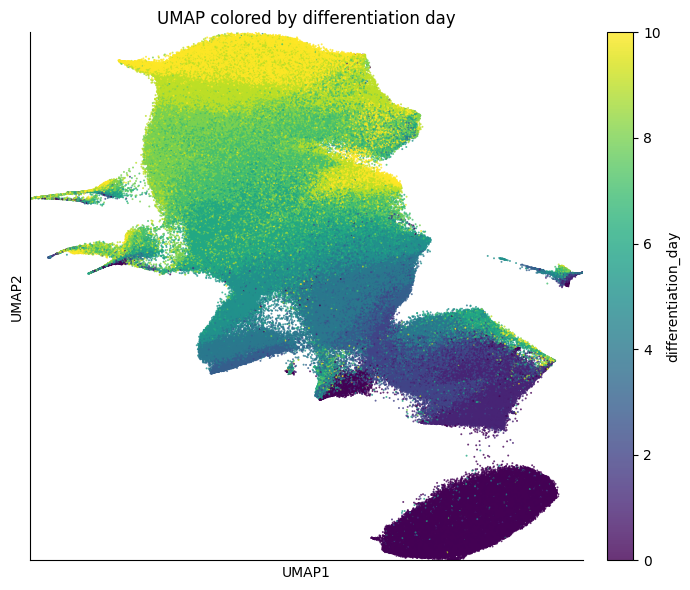

In [13]:
umap_continuous_figure(df_plot, "differentiation_day",
                       outbase="figs/umap_day_viridis",
                       title="UMAP colored by differentiation day",
                       cmap="viridis")

(<Figure size 700x600 with 1 Axes>,
 <Axes: title={'center': 'TroponinT_classifier'}, xlabel='UMAP1', ylabel='UMAP2'>)

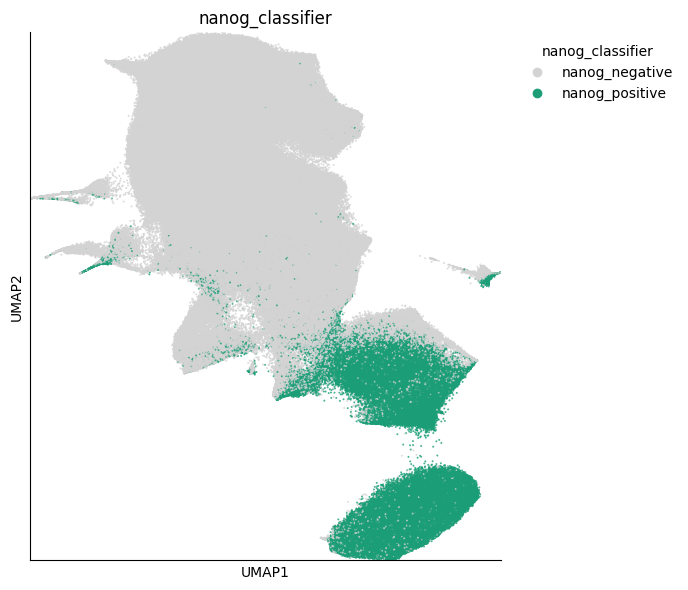

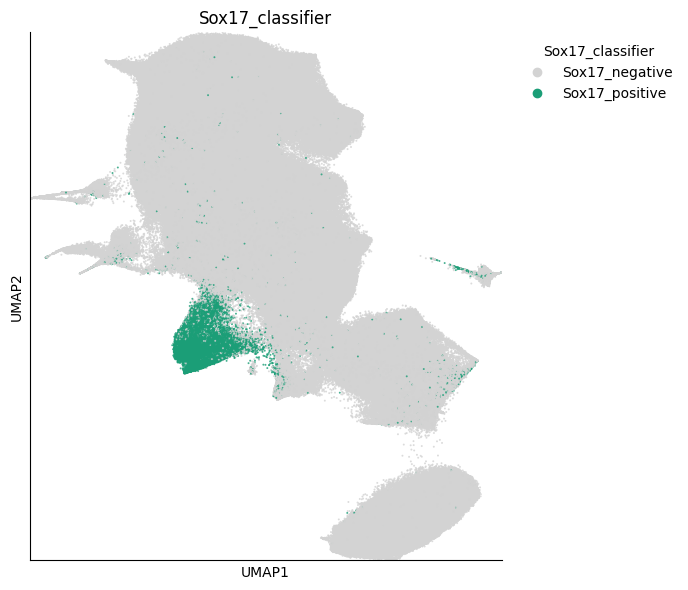

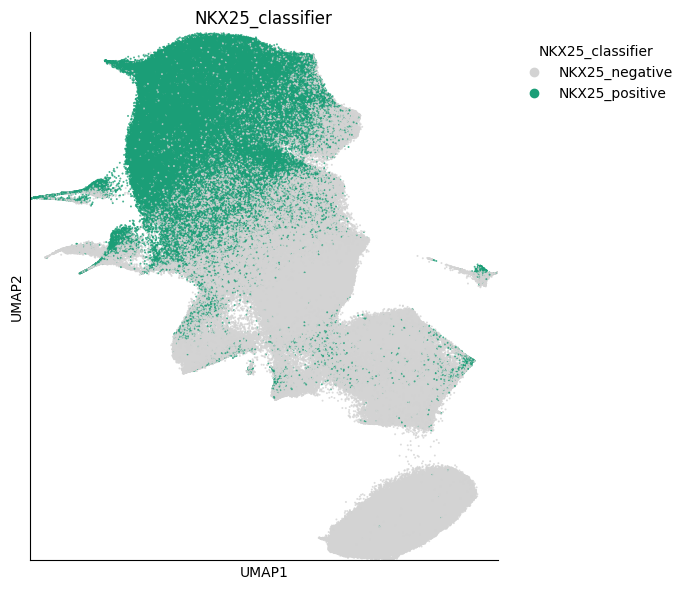

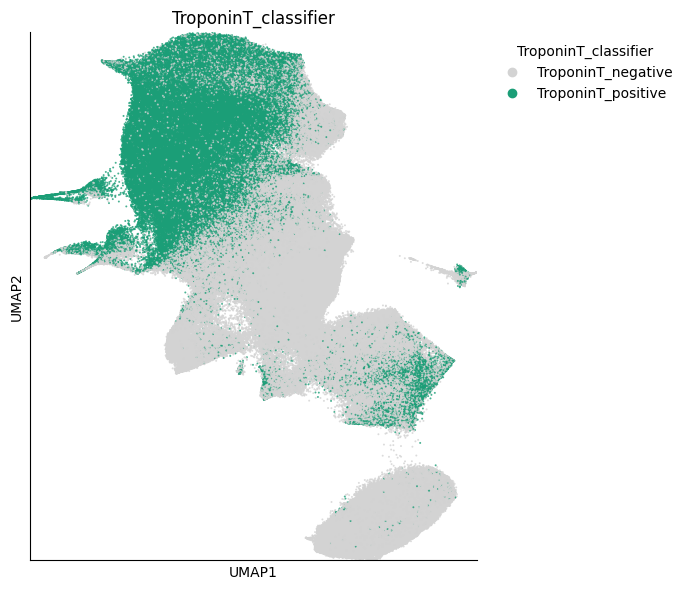

In [14]:
umap_categorical_figure(df_plot, "nanog_classifier", outbase="figs/umap_nanog")
umap_categorical_figure(df_plot, "Sox17_classifier", outbase="figs/umap_sox17")
umap_categorical_figure(df_plot, "NKX25_classifier", outbase="figs/umap_nkx25")
umap_categorical_figure(df_plot, "TroponinT_classifier", outbase="figs/umap_troponinT")

In [20]:
df

nuclei_filtered_Morphology_area  nuclei_filtered_Morphology_centroid-0  \
label                                                                           
214                             6109.0                              87.627602   
215                             4718.0                              92.093262   
216                             4599.0                              91.097412   
217                             8068.0                             101.037308   
219                             3333.0                              88.151215   
...                                ...                                    ...   
73957                           3611.0                            2074.994385   
73964                           2288.0                            2075.985107   
73970                           2258.0                            2083.329590   
73978                           2402.0                            2074.787598   
73997                           2146.0                            2086.249268   

       nuclei_filtered_Morphology_centroid-1  \
label                                          
214                              1664.032715   
215                               165.185242   
216                              1477.827148   
217                               431.152832   
219                              1583.671509   
...                                      ...   
73957                             710.316284   
73964                             260.677002   
73970                             184.254211   
73978                             395.848450   
73997                            2250.247559   

       nuclei_filtered_Morphology_well_centroid-0  \
label                                               
214                                     87.627602   
215                                     92.093262   
216                                     91.097412   
217                                    101.037308   
219                                     88.151215   
...                                           ...   
73957                                19354.994141   
73964                                19355.984375   
73970                                19363.330078   
73978                                19354.787109   
73997                                19366.250000   

       nuclei_filtered_Morphology_well_centroid-1  \
label                                               
214                                   9344.033203   
215                                    165.185242   
216                                   6597.827148   
217                                   2991.152832   
219                                  14383.671875   
...                                           ...   
73957                                18630.316406   
73964                                10500.676758   
73970                                10424.253906   
73978                                18315.847656   
73997                                 9930.247070   

       nuclei_filtered_Morphology_bbox_area  \
label                                         
214                                  8475.0   
215                                  6162.0   
216                                  5920.0   
217                                  9797.0   
219                                  4599.0   
...                                     ...   
73957                                4900.0   
73964                                3283.0   
73970                                3213.0   
73978                                3034.0   
73997                                3397.0   

       nuclei_filtered_Morphology_bbox-0  nuclei_filtered_Morphology_bbox-1  \
label                                                                         
214                                 50.0                             1613.0   
215                                 51.0                              126.0   
216                 

In [15]:
# Make plots of percentage positive per day over time course
CLASSIFIERS = {
    "nanog_classifier": "nanog_positive",
    "Sox17_classifier": "Sox17_positive",
    "NKX25_classifier": "NKX25_positive",
    "TroponinT_classifier": "TroponinT_positive",
}

rows = []

for clf_col, pos_label in CLASSIFIERS.items():
    tmp = (
        df
        .assign(is_positive=lambda d: d[clf_col] == pos_label)
        .groupby("differentiation_day")
        .agg(
            n_cells=("is_positive", "size"),
            n_positive=("is_positive", "sum"),
        )
        .reset_index()
    )

    tmp["percent_positive"] = 100 * tmp["n_positive"] / tmp["n_cells"]
    tmp["classifier"] = clf_col

    rows.append(tmp)

summary_df = pd.concat(rows, ignore_index=True)

In [16]:
summary_df

differentiation_day  n_cells  n_positive  percent_positive  \
0                     0   134502      128907         95.840211   
1                     1    55680       54067         97.103089   
2                     2    48406       38448         79.428170   
3                     3    29586        7625         25.772325   
4                     4    66873        3665          5.480538   
5                     5    65437        1222          1.867445   
6                     6    98287         286          0.290985   
7                     7   107978          91          0.084276   
8                     8   103751         116          0.111806   
9                     9    86645          62          0.071556   
10                   10    85766          47          0.054800   
11                    0   134502          36          0.026765   
12                    1    55680         462          0.829741   
13                    2    48406         223          0.460687   
14                    3    29586        7065         23.879538   
15                    4    66873       16606         24.832145   
16                    5    65437       13266         20.272934   
17                    6    98287         659          0.670485   
18                    7   107978          58          0.053715   
19                    8   103751         292          0.281443   
20                    9    86645          48          0.055398   
21                   10    85766         148          0.172563   
22                    0   134502          42          0.031226   
23                    1    55680         772          1.386494   
24                    2    48406        1749          3.613188   
25                    3    29586         786          2.656662   
26                    4    66873         338          0.505436   
27                    5    65437        6413          9.800266   
28                    6    98287       32650         33.219042   
29                    7   107978       71438         66.159773   
30                    8   103751       85141         82.062823   
31                    9    86645       67300         77.673264   
32                   10    85766       72202         84.184875   
33                    0   134502        1050          0.780658   
34                    1    55680       18575         33.360273   
35                    2    48406        3701          7.645746   
36                    3    29586         686          2.318664   
37                    4    66873         924          1.381724   
38                    5    65437        1253          1.914819   
39                    6    98287       40447         41.151933   
40                    7   107978       79215         73.362166   
41                    8   103751       81856         78.896589   
42                    9    86645       58555         67.580357   
43                   10    85766       56636         66.035492   

              classifier  
0       nanog_classifier  
1       nanog_classifier  
2       nanog_classifier  
3       nanog_classifier  
4       nanog_classifier  
5       nanog_classifier  
6       nanog_classifier  
7       nanog_classifier  
8       nanog_classifier  
9       nanog_classifier  
10      nanog_classifier  
11      Sox17_classifier  
12      Sox17_classifier  
13      Sox17_classifier  
14      Sox17_classifier  
15      Sox17_classifier  
16      Sox17_classifier  
17      Sox17_classifier  
18      Sox17_classifier  
19      Sox17_classifier  
20      Sox17_classifier  
21      Sox17_classifier  
22      NKX25_classifier  
23      NKX25_classifier  
24      NKX25_classifier  
25      NKX25_classifier  
26      NKX25_classifier  
27      NKX25_classifier  
28      NKX25_classifier  
29      NKX25_classifier  
30      NKX25_classifier  
31      NKX25_classifier  
32      NKX25_classifier  
33  TroponinT_classifier  
34  TroponinT_classifier  
35  TroponinT_classifier  
36  TroponinT_classifier  
37  Tro

In [17]:
summary_df.pivot(
    index="differentiation_day",
    columns="classifier",
    values="percent_positive",
)

classifier           NKX25_classifier  Sox17_classifier  TroponinT_classifier  \
differentiation_day                                                             
0                            0.031226          0.026765              0.780658   
1                            1.386494          0.829741             33.360273   
2                            3.613188          0.460687              7.645746   
3                            2.656662         23.879538              2.318664   
4                            0.505436         24.832145              1.381724   
5                            9.800266         20.272934              1.914819   
6                           33.219042          0.670485             41.151933   
7                           66.159773          0.053715             73.362166   
8                           82.062823          0.281443             78.896589   
9                           77.673264          0.055398             67.580357   
10                          84.184875          0.172563             66.035492   

classifier           nanog_classifier  
differentiation_day                    
0                           95.840211  
1                           97.103089  
2                           79.428170  
3                           25.772325  
4                            5.480538  
5                            1.867445  
6                            0.290985  
7                            0.084276  
8                            0.111806  
9                            0.071556  
10                           0.054800

In [18]:
COLORS = {
    "nanog_classifier": "#1b9e77",      # Dark2 green
    "Sox17_classifier": "#d95f02",     # Dark2 orange
    "NKX25_classifier": "#7570b3",     # Dark2 purple
    "TroponinT_classifier": "#e7298a", # Dark2 pink
}

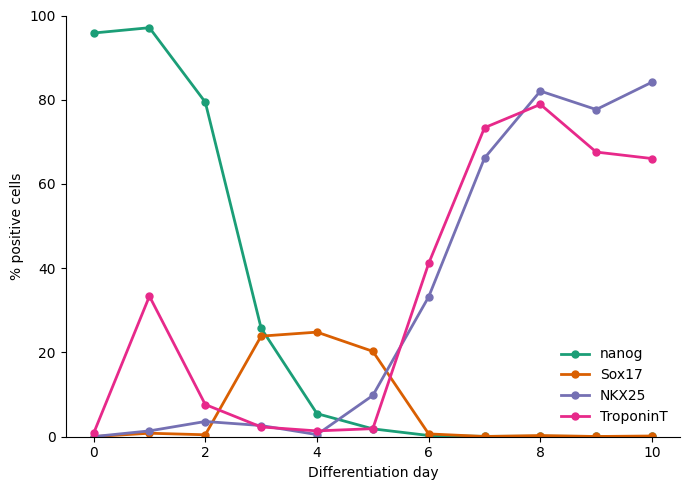

In [19]:
fig, ax = plt.subplots(figsize=(7, 5))

for clf, color in COLORS.items():
    d = summary_df[summary_df["classifier"] == clf]
    ax.plot(
        d["differentiation_day"],
        d["percent_positive"],
        marker="o",
        linewidth=2,
        markersize=5,
        label=clf.replace("_classifier", ""),
        color=color,
    )

ax.set_xlabel("Differentiation day")
ax.set_ylabel("% positive cells")
ax.set_ylim(0, 100)

ax.legend(frameon=False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

fig.tight_layout()
plt.show()

In [21]:
rows = []

for clf_col, pos_label in CLASSIFIERS.items():
    tmp = (
        df
        .assign(is_positive=lambda d: d[clf_col] == pos_label)
        .groupby(["differentiation_day", "well_name"])
        .agg(
            n_cells=("is_positive", "size"),
            n_positive=("is_positive", "sum"),
        )
        .reset_index()
    )

    tmp["percent_positive"] = 100 * tmp["n_positive"] / tmp["n_cells"]
    tmp["classifier"] = clf_col

    rows.append(tmp)

per_well_df = pd.concat(rows, ignore_index=True)

In [23]:
summary_df = (
    per_well_df
    .groupby(["differentiation_day", "classifier"])
    .agg(
        mean_percent=("percent_positive", "mean"),
        n_wells=("percent_positive", "size"),
        std_percent=("percent_positive", "std"),
    )
    .reset_index()
)
summary_df

differentiation_day            classifier  mean_percent  n_wells  \
0                     0      NKX25_classifier      0.030786        4   
1                     0      Sox17_classifier      0.027569        4   
2                     0  TroponinT_classifier      0.768468        4   
3                     0      nanog_classifier     95.629656        4   
4                     1      NKX25_classifier      1.490579        2   
5                     1      Sox17_classifier      0.789336        2   
6                     1  TroponinT_classifier     32.970679        2   
7                     1      nanog_classifier     96.983192        2   
8                     2      NKX25_classifier      3.451259        2   
9                     2      Sox17_classifier      0.576372        2   
10                    2  TroponinT_classifier      7.168672        2   
11                    2      nanog_classifier     79.749614        2   
12                    3      NKX25_classifier      2.656662        1   
13                    3      Sox17_classifier     23.879538        1   
14                    3  TroponinT_classifier      2.318664        1   
15                    3      nanog_classifier     25.772325        1   
16                    4      NKX25_classifier      0.507791        2   
17                    4      Sox17_classifier     25.166186        2   
18                    4  TroponinT_classifier      1.413440        2   
19                    4      nanog_classifier      5.663889        2   
20                    5      NKX25_classifier     10.577096        2   
21                    5      Sox17_classifier     21.447668        2   
22                    5  TroponinT_classifier      2.062186        2   
23                    5      nanog_classifier      2.325041        2   
24                    6      NKX25_classifier     33.008390        2   
25                    6      Sox17_classifier      0.726492        2   
26                    6  TroponinT_classifier     41.640568        2   
27                    6      nanog_classifier      0.310746        2   
28                    7      NKX25_classifier     66.206883        2   
29                    7      Sox17_classifier      0.053768        2   
30                    7  TroponinT_classifier     73.616182        2   
31                    7      nanog_classifier      0.084170        2   
32                    8      NKX25_classifier     81.723221        2   
33                    8      Sox17_classifier      0.279231        2   
34                    8  TroponinT_classifier     78.527535        2   
35                    8      nanog_classifier      0.112415        2   
36                    9      NKX25_classifier     77.599553        2   
37                    9      Sox17_classifier      0.055375        2   
38                    9  TroponinT_classifier     67.438161        2   
39                    9      nanog_classifier      0.070997        2   
40                   10      NKX25_classifier     84.185308        2   
41                   10      Sox17_classifier      0.172888        2   
42                   10  TroponinT_classifier     66.029516        2   
43                   10      nanog_classifier      0.054783        2   

    std_percent  
0      0.006998  
1      0.013083  
2      0.288945  
3      4.656323  
4      1.296018  
5      0.503108  
6      4.851033  
7      1.492907  
8      0.937195  
9      0.669545  
10     2.761142  
11     1.860408  
12          NaN  
13          NaN  
14          NaN  
15          NaN  
16     0.060612  
17     8.596259  
18     0.816185  
19     4.718376  
20     4.301919  
21     6.505421  
22     0.816089  
23     2.534069  
24     2.058372  
25     0.547261  
26     4.774675  
27     0.193100  
28     1.251535  
29     0.001428  
30     6.748297  
31     0.002832  
32     7.328811  
33     0.047728  
34     7.964383  
35     0.013144  
36     4.421025  
37     0.001418  
38     8.528597  
39     0.033541  
40     0.115756  
41     

In [26]:
from pathlib import Path

def savefig_both(fig, outbase, dpi_png=300, dpi_pdf=600):
    """
    Save a matplotlib figure as both PNG and PDF.

    Parameters
    ----------
    fig : matplotlib.figure.Figure
        The figure to save.
    outbase : str or Path
        Path without suffix, e.g. "figs/percent_positive_over_time"
    dpi_png : int
        DPI for PNG (300–600 typical)
    dpi_pdf : int
        DPI for rasterized artists in PDF (600–1200 typical)
    """
    outbase = Path(outbase)
    outbase.parent.mkdir(parents=True, exist_ok=True)

    fig.savefig(outbase.with_suffix(".png"), dpi=dpi_png, bbox_inches="tight")
    fig.savefig(outbase.with_suffix(".pdf"), dpi=dpi_pdf, bbox_inches="tight")

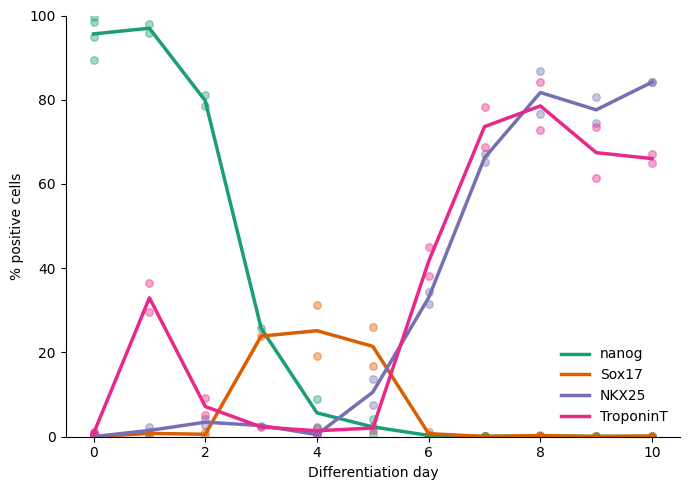

In [27]:
COLORS = {
    "nanog_classifier": "#1b9e77",
    "Sox17_classifier": "#d95f02",
    "NKX25_classifier": "#7570b3",
    "TroponinT_classifier": "#e7298a",
}

fig, ax = plt.subplots(figsize=(7, 5))

for clf, color in COLORS.items():
    # individual wells
    d_rep = per_well_df[per_well_df["classifier"] == clf]
    ax.scatter(
        d_rep["differentiation_day"],
        d_rep["percent_positive"],
        color=color,
        alpha=0.4,
        s=30,
    )

    # mean line
    d_mean = summary_df[summary_df["classifier"] == clf]
    ax.plot(
        d_mean["differentiation_day"],
        d_mean["mean_percent"],
        color=color,
        linewidth=2.5,
        label=clf.replace("_classifier", ""),
    )

ax.set_xlabel("Differentiation day")
ax.set_ylabel("% positive cells")
ax.set_ylim(0, 100)

ax.legend(frameon=False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

fig.tight_layout()
plt.show()

fig.tight_layout()

savefig_both(fig, "figs/percent_positive_over_time")

# Hyperparameter tuning

In [ ]:
# For testing purposes, work on a subset of the data
df_sub = df.sample(n=100_000, random_state=0)
del df
exclude_cols = [
    "well_name", "ROI",
    "nanog_classifier", "Sox17_classifier",
    "NKX25_classifier", "TroponinT_classifier",
    "differentiation_day",
]

X_scaled = StandardScaler().fit_transform(df_sub.drop(columns=exclude_cols))
pca = PCA(n_components=50, random_state=0)
X_pca = pca.fit_transform(X_scaled)
n_neighbors = 30  # test 10 - 100
min_dist = 0.05 # test 0.01 - 0.3
random_state=42

In [ ]:
reducer = umap.UMAP(
    n_neighbors=n_neighbors,
    min_dist=min_dist,
    n_components=2,
    metric="euclidean",
    # random_state=random_state,
)
embedding = reducer.fit_transform(X_pca)

In [ ]:
df_sub = df_sub.copy()
df_sub["UMAP1"] = embedding[:, 0]
df_sub["UMAP2"] = embedding[:, 1]

In [11]:
def umap_scatter_continuous(df_plot, c, title=None, s=2, alpha=0.6, cmap="viridis",
                           vmin=None, vmax=None, log_color=False):
    x = df_plot["UMAP1"].to_numpy()
    y = df_plot["UMAP2"].to_numpy()
    vals = df_plot[c].to_numpy()

    if log_color:
        vals = np.log1p(vals)

    plt.figure(figsize=(7, 6))
    sc = plt.scatter(x, y, c=vals, s=s, alpha=alpha, linewidths=0,
                     cmap=cmap, vmin=vmin, vmax=vmax, rasterized=True)
    plt.xlabel("UMAP1")
    plt.ylabel("UMAP2")
    plt.title(title or f"UMAP colored by {c}")
    cb = plt.colorbar(sc)
    cb.set_label(f"{c}" + (" (log1p)" if log_color else ""))
    plt.tight_layout()
    plt.show()


def umap_scatter_categorical(df_plot, cat, title=None, s=2, alpha=0.6, max_categories=30):
    x = df_plot["UMAP1"].to_numpy()
    y = df_plot["UMAP2"].to_numpy()
    cats = df_plot[cat].astype("category")

    # Keep the legend sane
    if cats.nunique() > max_categories:
        # show top categories, rest -> "Other"
        top = cats.value_counts().index[:max_categories]
        cats = cats.where(cats.isin(top), other="Other").astype("category")

    plt.figure(figsize=(7, 6))
    for k in cats.cat.categories:
        m = (cats == k).to_numpy()
        plt.scatter(x[m], y[m], s=s, alpha=alpha, linewidths=0, label=str(k), rasterized=True)

    plt.xlabel("UMAP1")
    plt.ylabel("UMAP2")
    plt.title(title or f"UMAP colored by {cat}")
    plt.legend(markerscale=4, bbox_to_anchor=(1.02, 1), loc="upper left", frameon=False)
    plt.tight_layout()
    plt.show()

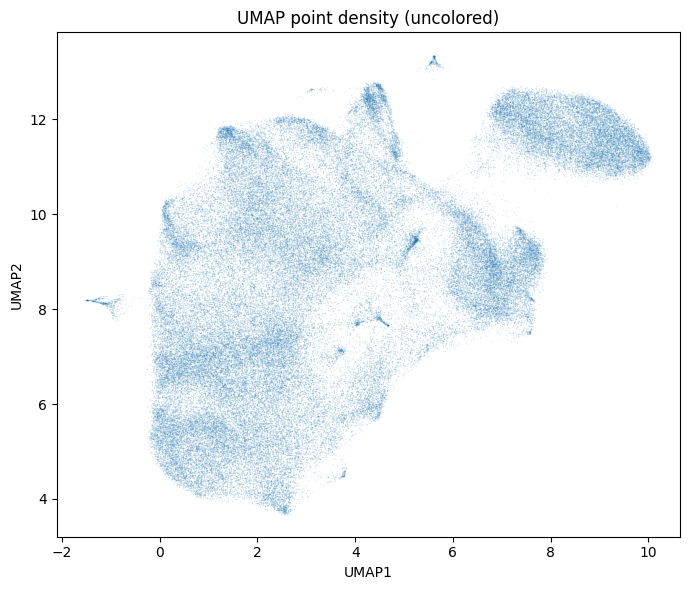

In [40]:
plt.figure(figsize=(7,6))
plt.scatter(df_sub["UMAP1"], df_sub["UMAP2"], s=1, alpha=0.15, linewidths=0, rasterized=True)
plt.xlabel("UMAP1"); plt.ylabel("UMAP2"); plt.title("UMAP point density (uncolored)")
plt.tight_layout(); plt.show()

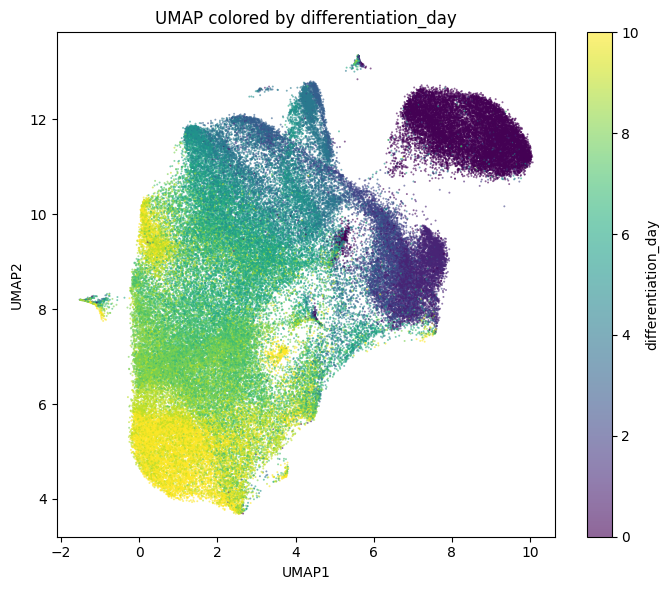

In [41]:
# umap_scatter_categorical(df_sub, "differentiation_day", max_categories=20)
umap_scatter_continuous(df_sub, "differentiation_day", cmap="viridis")

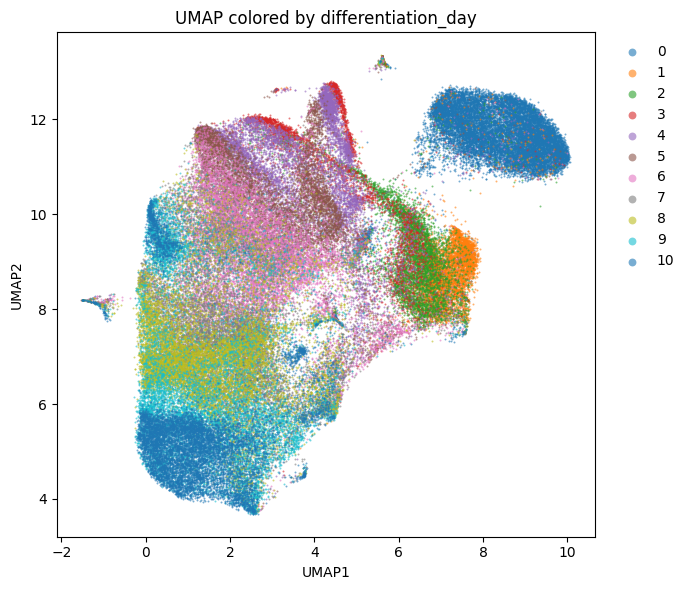

In [42]:
umap_scatter_categorical(df_sub, "differentiation_day", max_categories=20)

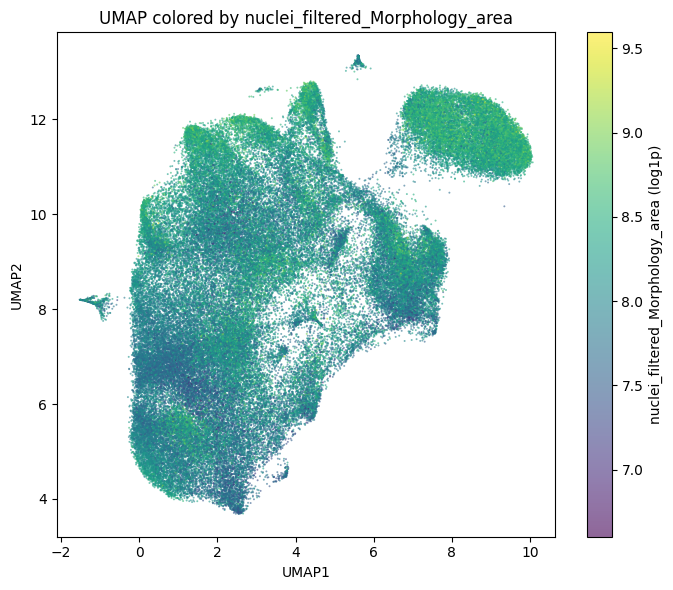

In [43]:
area_col = 'nuclei_filtered_Morphology_area'
umap_scatter_continuous(df_sub, area_col, log_color=True, cmap="viridis")

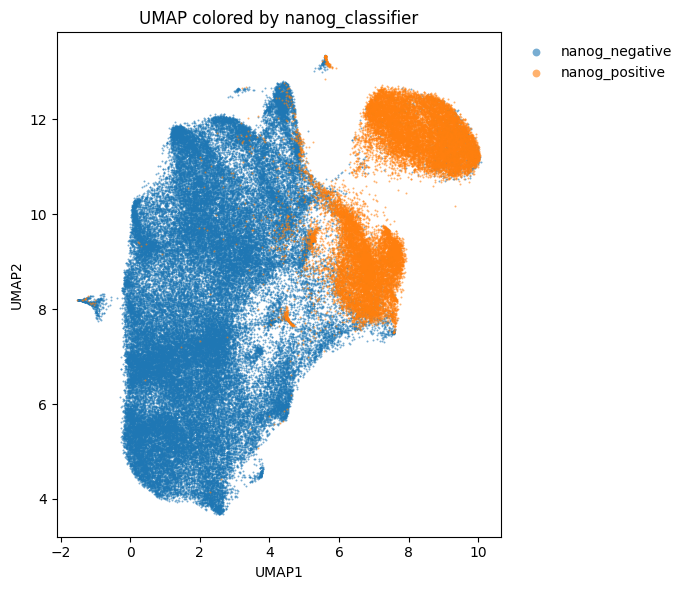

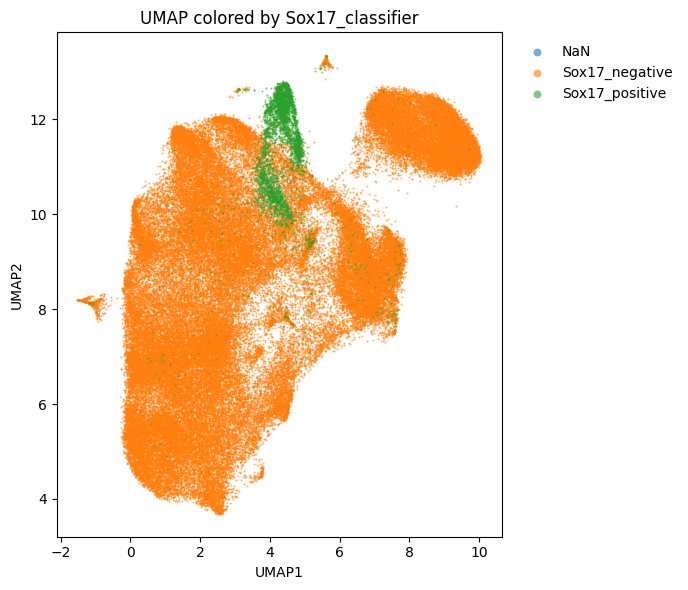

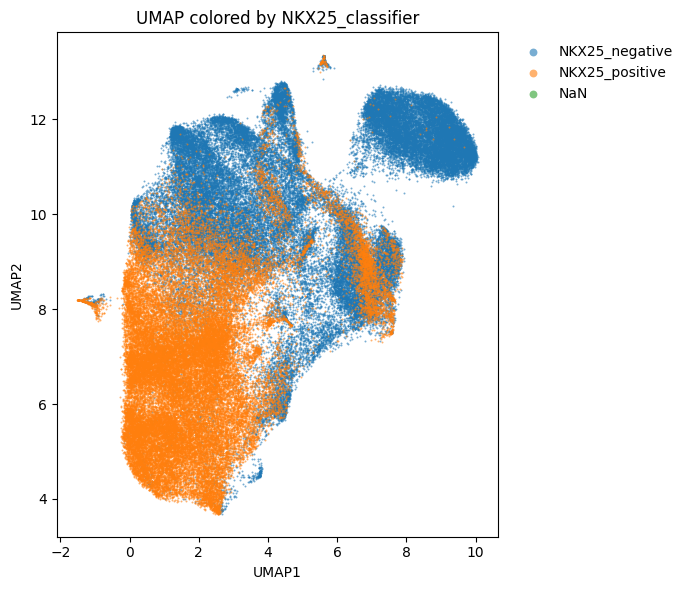

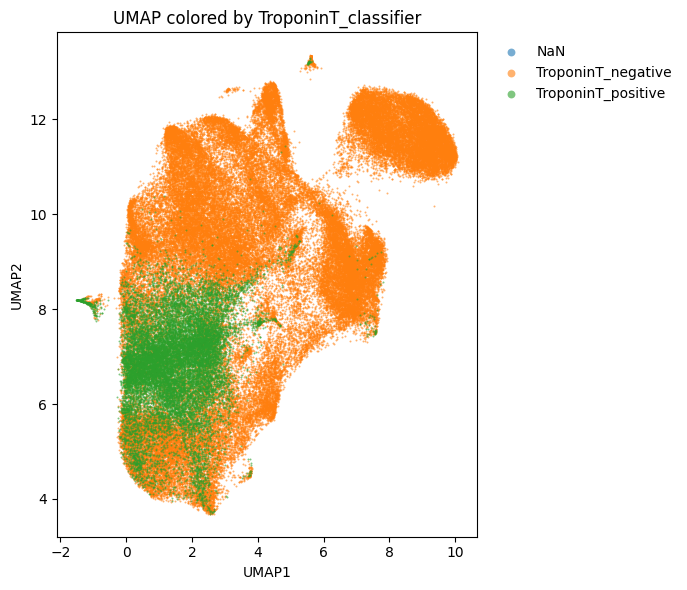

In [44]:
umap_scatter_categorical(df_sub, "nanog_classifier")
umap_scatter_categorical(df_sub, "Sox17_classifier")
umap_scatter_categorical(df_sub, "NKX25_classifier")
umap_scatter_categorical(df_sub, "TroponinT_classifier")

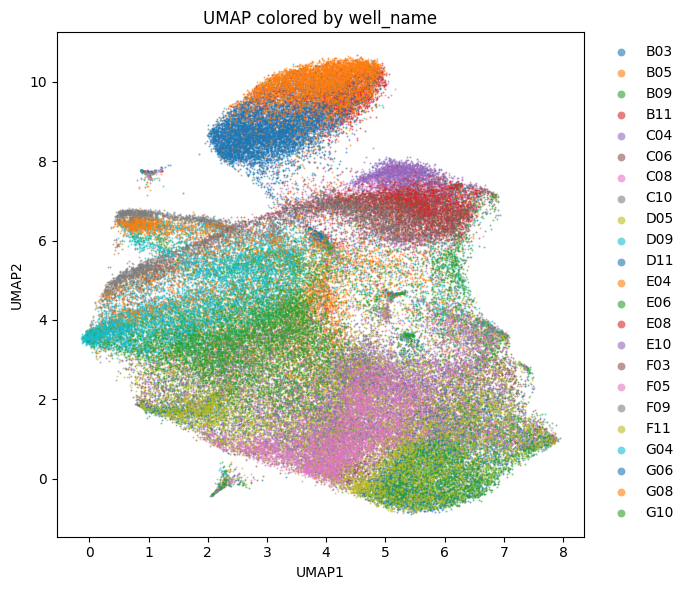

In [20]:
umap_scatter_categorical(df_sub, "well_name")
# umap_scatter_categorical(df_sub, "ROI")

In [28]:
df_sub["nanog_classifier"] = (
    df_sub["nanog_classifier"]
    .cat.remove_unused_categories()
)

col = "nanog_classifier"
vals = df_sub[col]

print(vals.dtype)
print(vals.unique())

# Catch common fake-nan strings
fake_nan = vals.astype(str).str.strip().str.lower().isin(["nan", "none", "null", ""])
print("fake-nan count:", fake_nan.sum())
print("examples:", vals[fake_nan].head())

category
['nanog_negative', 'nanog_positive']
Categories (2, object): ['nanog_negative', 'nanog_positive']
fake-nan count: 0
examples: Series([], Name: nanog_classifier, dtype: category
Categories (2, object): ['nanog_negative', 'nanog_positive'])
